In [20]:
from typing import Callable, List, Tuple

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions.distribution import Distribution
from pytorch_lightning.loggers import TensorBoardLogger
import normflows as nf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
from NFconstants import N_nod, Beta, a
from NFandist import get_O
from NFandist import get_diag
from NFandist import get_C

def set_random_seed(seed):
    torch.manual_seed(seed)
O=(torch.tensor(get_O(N_nod)).float()).to(device)
Ot=(torch.t(O)).to(device)
print(Ot.requires_grad)


C=(torch.tensor(get_C(N_nod,Beta)).float()).to(device)
Ct=(torch.t(C)).to(device)




False


In [35]:
def configure_theta_lib():
    hidden_dim = N_nod*32
    num_hidden = 2
    netlist=[hidden_dim]*(num_hidden+2)
    netlist[0]=N_nod//2
    netlist[-1]=N_nod
    theta = nf.nets.MLP(netlist,leaky=0.01, init_zeros=True)
    return theta

In [36]:
def configure_flows_lib(n_flows):
    flows = []
    for i in range(n_flows):
        flows.append(nf.flows.AffineCouplingBlock(configure_theta_lib()))
        flows.append(nf.flows.Permute(2, mode='swap'))
    return flows

In [37]:
class Pipeline_lib(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs


    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        z = batch
        x, log_abs_det = self.model.forward_and_log_det(z)
        x = torch.matmul(x,Ot.to(x.device))
        loss = self.loss(x,log_abs_det)
        self.log('train_loss', loss, prog_bar=True)
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    

In [38]:
from NFoscillator import Oscillator
from NFrel_oscillator import Rel_Oscillator
from NFur_oscillator import Ur_Oscillator
from NFx4 import X4
from NFMorse import Morse
from NFrel_Morse import Rel_Morse
from NFrel_Columb import Rel_Columb
osc=Oscillator(N_nod,Beta)
KL_osc=osc.get_KL()
KL_mat_osc=osc.get_mat_KL()
KL_rel001=Rel_Oscillator.make_KL(Rel_Oscillator,N_nod,Beta,sigma=0.01)
KL_rel01=Rel_Oscillator.make_KL(Rel_Oscillator,N_nod,Beta,sigma=0.1)
KL_rel1=Rel_Oscillator.make_KL(Rel_Oscillator,N_nod,Beta,sigma=1)
KL_rel10=Rel_Oscillator.make_KL(Rel_Oscillator,N_nod,Beta,sigma=10)
KL_ur=Ur_Oscillator.make_KL(Ur_Oscillator,N_nod,Beta)

KL_rel29=Rel_Oscillator.make_KL(Rel_Oscillator,N_nod,Beta,sigma = 2 ** 9)

KL_X4=X4.make_KL(X4,N_nod,Beta,g=0.05)
KL_morse=Morse.make_KL(Morse,N_nod,Beta,alpha=1)
KL_rel_morse=Rel_Morse(N_nod,Beta,alpha=1,m=1000).get_KL()

KL_rel_columb=Rel_Columb(N_nod,Beta,alpha=1,R=1).get_KL()

In [40]:
from Data import train_loader

set_random_seed(42)
base = nf.distributions.base.DiagGaussian(N_nod)
#nf=NormalizingFlow(latent=normal_dist,flows=configure_flows(12),ort=True)
model = nf.NormalizingFlow(base,configure_flows_lib(12))
pipeline = Pipeline_lib(model=model, criterion=KL_rel1, optimizer_class=torch.optim.Adam, optimizer_kwargs={"lr": 0.0001,"weight_decay":0.0})

trainer = pl.Trainer(
    max_epochs=50,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    accumulate_grad_batches=1
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
torch.save(model.state_dict(), "model_weights1.pth")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type            | Params
------------------------------------------
0 | model | NormalizingFlow | 52.7 M
1 | loss  | KL_with_S       | 0     
------------------------------------------
52.7 M    Trainable params
0         Non-trainable params
52.7 M    Total params
210.964   Total estimated model params size (MB)


Epoch 0:  23%|██▎       | 233/1024 [09:56<33:45,  0.39it/s, v_num=60, train_loss=50.30]

/home/jupyter/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [41]:
from Data import normal_dist
import numpy as np
from NFconstants import N_traj
set_random_seed(42)
NF_trained= nf.NormalizingFlow(base,configure_flows_lib(12))
NF_trained.load_state_dict(torch.load('model_weights1.pth'))
NF_trained.eval()
trajs , _ = NF_trained.sample(N_traj)
trajs=torch.matmul(trajs,Ot.to(trajs.device))

In [42]:
from NFandist import get_T
def G(X,n_p=N_nod):
    n_nod=(X.shape)[1]
    T=torch.tensor(get_T(n_nod)).float()
    G=np.zeros((n_p))
    Y=X.clone()
    Xt=torch.t(X)
    for s in range(n_p):
        G[s]=torch.trace(torch.matmul(Y,Xt))
        Y=torch.matmul(Y,T)
    return G/(N_traj*n_nod)
g_nf=G(trajs)

In [ ]:
from NFandist import calc_G
from NFconstants import N_nod, N_traj, NG_points,Beta
g_osc=calc_G(N_nod,Beta,N_nod)


In [ ]:
g_ur = [0.476546, 0.148654, 0.060357, 0.0232596, -0.00447499, -0.00224423, -0.00447499, 0.0232596, 0.060357, 0.148654]

In [ ]:

g_ur = [0.555858, 0.497988, 0.446597, 0.401115, 0.360415, 0.324316, 0.29138, 0.261791, 0.235658, 0.211969, 0.190536, 0.171994, 0.155133, 0.140335, 0.126598, 0.114471, 0.103514, 0.0941716, 0.0852865, 0.0767528, 0.0691313, 0.0619047, 0.0550745, 0.0490998, 0.0443236, 0.0396256, 0.0358628, 0.0324961, 0.0302019, 0.0276177, 0.0251373, 0.0226234, 0.0203086, 0.0179717, 0.0164385, 0.0152739, 0.0143051, 0.0136778, 0.0127566, 0.0118486, 0.0111658, 0.0111462, 0.011026, 0.0110081, 0.0109681, 0.0106729, 0.0101027, 0.010377, 0.010866, 0.0114044, 0.0119873, 0.0114044, 0.010866, 0.010377, 0.0101027, 0.0106729, 0.0109681, 0.0110081, 0.011026, 0.0111462, 0.0111658, 0.0118486, 0.0127566, 0.0136778, 0.0143051, 0.0152739, 0.0164385, 0.0179717, 0.0203086, 0.0226234, 0.0251373, 0.0276177, 0.0302019, 0.0324961, 0.0358628, 0.0396256, 0.0443236, 0.0490998, 0.0550745, 0.0619047, 0.0691313, 0.0767528, 0.0852865, 0.0941716, 0.103514, 0.114471, 0.126598, 0.140335, 0.155133, 0.171994, 0.190536, 0.211969, 0.235658, 0.261791, 0.29138, 0.324316, 0.360415, 0.401115, 0.446597, 0.497988]


In [ ]:
g_rel = [0.389004, 0.174591, 0.0750764, 0.0320855, 0.0235634, 0.0204869, 0.0235634, 0.0320855, 0.0750764, 0.174591]

In [15]:
g_rel = [0.392501, 0.361773, 0.333519, 0.307446, 0.283335, 0.261201, 0.240658, 0.221871, 0.204776, 0.188963, 0.174495, 0.161116, 0.148541, 0.136946, 0.126175, 0.116168, 0.106934, 0.0985733, 0.090693, 0.0836987, 0.0773237, 0.0713712, 0.0662134, 0.0611666, 0.0567049, 0.0525145, 0.0489322, 0.045775, 0.043085, 0.0407685, 0.0383386, 0.0365845, 0.0353032, 0.0339074, 0.0324167, 0.0308972, 0.0295226, 0.0285374, 0.0276133, 0.026899, 0.0265193, 0.0267518, 0.027023, 0.0272673, 0.0275789, 0.0277296, 0.0281657, 0.0286108, 0.0289897, 0.0292072, 0.0292838, 0.0292072, 0.0289897, 0.0286108, 0.0281657, 0.0277296, 0.0275789, 0.0272673, 0.027023, 0.0267518, 0.0265193, 0.026899, 0.0276133, 0.0285374, 0.0295226, 0.0308972, 0.0324167, 0.0339074, 0.0353032, 0.0365845, 0.0383386, 0.0407685, 0.043085, 0.045775, 0.0489322, 0.0525145, 0.0567049, 0.0611666, 0.0662134, 0.0713712, 0.0773237, 0.0836987, 0.090693, 0.0985733, 0.106934, 0.116168, 0.126175, 0.136946, 0.148541, 0.161116, 0.174495, 0.188963, 0.204776, 0.221871, 0.240658, 0.261201, 0.283335, 0.307446, 0.333519, 0.361773]


In [ ]:

import numpy as np
corr = [0.0049279, 0.00445719, 0.0040318, 0.00364688, 0.00329375, 0.00297512, 0.00268571, 0.00242197, 0.00217813, 0.00195686, 0.00176504, 0.001597, 0.0014406, 0.00130362, 0.00117932, 0.00107197, 0.000971531, 0.000873839, 0.000783014, 0.000698531, 0.000622945, 0.000554938, 0.000497423, 0.000446639, 0.000400234, 0.000360026, 0.000325092, 0.00028936, 0.000252744, 0.000222755, 0.00019756, 0.000178826, 0.000169581, 0.000165766, 0.000161208, 0.000158499, 0.000157808, 0.000156267, 0.000155463, 0.000151827, 0.000137475, 0.000124214, 0.000113485, 0.000104859, 9.63436e-05, 8.8317e-05, 8.17296e-05, 7.9884e-05, 7.83747e-05, 8.01024e-05, 8.44507e-05, 8.01024e-05, 7.83747e-05, 7.9884e-05, 8.17296e-05, 8.8317e-05, 9.63436e-05, 0.000104859, 0.000113485, 0.000124214, 0.000137475, 0.000151827, 0.000155463, 0.000156267, 0.000157808, 0.000158499, 0.000161208, 0.000165766, 0.000169581, 0.000178826, 0.00019756, 0.000222755, 0.000252744, 0.00028936, 0.000325092, 0.000360026, 0.000400234, 0.000446639, 0.000497423, 0.000554938, 0.000622945, 0.000698531, 0.000783014, 0.000873839, 0.000971531, 0.00107197, 0.00117932, 0.00130362, 0.0014406, 0.001597, 0.00176504, 0.00195686, 0.00217813, 0.00242197, 0.00268571, 0.00297512, 0.00329375, 0.00364688, 0.0040318, 0.00445719, 0.0049279]
g_rel_001=(100*np.array(corr))[:-1]



In [ ]:
import numpy as np
corr = [0.0482165, 0.0437875, 0.0397512, 0.0361339, 0.0328051, 0.0297607, 0.0270138, 0.0244825, 0.0222039, 0.0201489, 0.0183026, 0.0166458, 0.0151002, 0.0137192, 0.012421, 0.0112716, 0.0102497, 0.00931179, 0.0084281, 0.00763501, 0.00697282, 0.00637519, 0.00579578, 0.00524782, 0.00469027, 0.00419239, 0.00376016, 0.00335117, 0.00299975, 0.00265075, 0.00236496, 0.00215769, 0.00196452, 0.00178665, 0.00162977, 0.00148276, 0.00135563, 0.00127519, 0.00120796, 0.00115448, 0.0011155, 0.00109623, 0.00112555, 0.00113097, 0.00108849, 0.00108302, 0.00112726, 0.00115736, 0.00118966, 0.00124266, 0.00121678, 0.00124266, 0.00118966, 0.00115736, 0.00112726, 0.00108302, 0.00108849, 0.00113097, 0.00112555, 0.00109623, 0.0011155, 0.00115448, 0.00120796, 0.00127519, 0.00135563, 0.00148276, 0.00162977, 0.00178665, 0.00196452, 0.00215769, 0.00236496, 0.00265075, 0.00299975, 0.00335117, 0.00376016, 0.00419239, 0.00469027, 0.00524782, 0.00579578, 0.00637519, 0.00697282, 0.00763501, 0.0084281, 0.00931179, 0.0102497, 0.0112716, 0.012421, 0.0137192, 0.0151002, 0.0166458, 0.0183026, 0.0201489, 0.0222039, 0.0244825, 0.0270138, 0.0297607, 0.0328051, 0.0361339, 0.0397512, 0.0437875, 0.0482165]
g_rel_01=(10*np.array(corr))[:-1]


0.4305340881347656


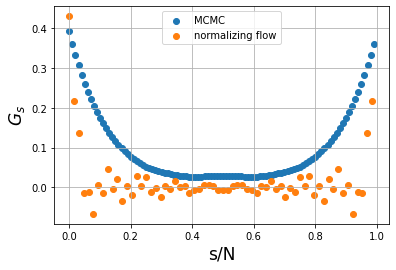

In [43]:
#import sys
#sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, N_traj, NG_points,Beta
#from Value import G
#import ensemble
#from NFoscillator import basic_oscillator
#from time import time
#from NFandist import calc_G

"""
ens_nf=ensemble.ensemble.load("nf_ensemble.txt",basic_oscillator)
g_nf=np.vstack(ensemble.ensemble.Vaverage_and_sigma(ens_nf,G))
g_nf=g_nf.transpose()[0]
"""

g=g_rel
print(g_nf[0])
fig=plt.figure()
MCMC_list=np.arange(len(g))/len(g)
NF_list=np.arange(len(g_nf))/len(g_nf)
plt.scatter(MCMC_list,g)
plt.scatter(NF_list,g_nf)
plt.xlabel(r"s/N",fontsize=17)
plt.ylabel(r"$G_s$",fontsize=17)
plt.legend(["MCMC","normalizing flow"])
plt.grid(True)
plt.show()


In [26]:
K = (1 - 2 * (g_nf[0]-g_nf[1]) / a) / (2 * a)
print(K)
V2=g_nf[0]/2
print((3/2)*K+(1/2)*V2)

0.16764257812500105
0.6877026062011735


In [2]:


! du -sh logs






1.6G	logs


In [3]:
! rm -rf logs


In [ ]:
def configure_flows(level_size,level_step=1):  # n_flows=8,...,12
    flows=[]
    n_levels=(N_latent-N_nod)//level_step
    
    if N_nod==N_latent:
        level_step=0
    
    dim=N_latent//2
    
    for i in range(n_levels):
        for k in range(level_size):
            flows.append(AffineCouplingLayer(configure_theta(dim,dim),split=pair_SplitFunc,swap=k%2))
        flows.append(nn.Linear(dim,dim-level_step//2))    
        dim-=level_step//2    
    
    if dim!=N_nod//2:
        print("smth wrong")
        
    for k in range(level_size):
        flows.append(AffineCouplingLayer(configure_theta(dim,dim),split=pair_SplitFunc,swap=k%2))
    flows = nn.ModuleList(flows)
    
    return flows 

In [11]:
print("start")
from Data import normal_dist

def configure_theta():
    theta=ThetaNetwork(
                in_dim = N_nod//2,
                out_dim = N_nod//2,
                num_hidden = 16,  #2 to 6
                hidden_dim = 2*N_nod , #100-1024
                num_params = 2,
                p_drop=0.4,
    )
    return theta

def configure_flows(n_flows):  # n_flows=8,...,12
    flows=[]
    
    flows.append(D(N_nod))
    
    for k in range(n_flows//4):
        flows.append(AffineCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=k%2))
        flows.append(L1(N_nod))
    
    for k in range(3 * n_flows//4):
        flows.append(AffineCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=k%2))
    
    flows.append(D(N_nod))    
    flows = nn.ModuleList(flows)
    return flows 

def configure_conv_flows(n_conv,kernel_size=3):
    conv_flows=[]
    for i in range(n_conv):
        conv_flows.append(AffineCouplingLayer(Conv_NN(N_nod//2,2,kernel_size),split=pair_SplitFunc,swap=i%2))
    conv_flows = nn.ModuleList(conv_flows)
    return conv_flows

print(normal_dist)

                  

start
Normal(loc: torch.Size([100]), scale: torch.Size([100]))


In [ ]:
from Data import normal_dist

def configure_theta():
    theta=ThetaNetwork(
                in_dim = N_nod//2,
                out_dim = N_nod//2,
                num_hidden = 16,  #2 to 6
                hidden_dim = 2 * N_nod , #100-1024
                num_params = 2,
                p_drop=0.0,
    )
    return theta

def configure_flows(n_flows):  # n_flows=8,...,12
    flows=[]
    
    flows.append(CubicCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=0))
    flows.append(CubicCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=1))
    
    flows.append(D(N_nod))

    for k in range(n_flows):
        flows.append(AffineCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=k%2))
            
    
    flows = nn.ModuleList(flows)
    return flows 